In [1]:
#import packages

import pandas as pd
import twint
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
from string import punctuation
import re
from nltk.stem import WordNetLemmatizer
import seaborn as sns
import textblob
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
init_notebook_mode(connected=True)

## Get Tweet Data

Before we start to analyize the data, we need a collection of tweets. So let's use Twint to scrape Twitter for all tweets that mention Billie Eilish. She will be our pilot subject that we'll use to gather data on so that we can start getting insights on her audience. Let's gather all tweets from the last year with 'billie eilish' as our search keyword.

In [2]:
#need a function to scrape twitter data


# c = twint.Config()


# c.Format = "ID {id} | Tweet {tweet}"
# c.Search = 'billie eilish'
# c.Lang = 'en'
# c.Pandas_clean = True
# c.Since = '2019-03-31'
# c.Store_csv = True
# c.Output = 'tweets.csv'
# twint.run.Search(c)



## Data Cleaning

In [3]:
#lets read in the dataframe

df = pd.read_csv('tweets.csv')


In [4]:
#how many tweets did we get?

df.shape

(14556, 34)

In [5]:
#let's see if there's anything missing from our dataframe and see if we can get rid of anything

df.isna().sum()

id                     0
conversation_id        0
created_at             0
date                   0
time                   0
timezone               0
user_id                0
username               0
name                   0
place              14554
tweet                  0
mentions               0
urls                   0
photos                 0
replies_count          0
retweets_count         0
likes_count            0
hashtags               0
cashtags               0
link                   0
retweet                0
quote_url          13731
video                  0
near               14556
geo                14556
source             14556
user_rt_id         14556
user_rt            14556
retweet_id         14556
reply_to               0
retweet_date       14556
translate          14556
trans_src          14556
trans_dest         14556
dtype: int64

In [6]:
df.drop(['place', 'quote_url', 'near', 'geo', 'source', 'user_rt_id', 'user_rt', 'retweet_id', 'retweet_date', 'translate', 
        'trans_src', 'trans_dest'], inplace=True, axis=1)

### Preprocess Raw Text



In [7]:
df.tweet.head(10)

0    #158: Rez Fail- when mercy tries to Rez and sh...
1                THIS! Has made my day! Gracias!!! 🥔🍠🍟
2                     Billie Eilish & Khalid-lovely 🎧👌
3    Do you guys an artist that you listen to and n...
4                       What the fuck is Billie Eilish
5       YASSSSSSSSSSSSSSSSSS\n\nGOOD JOB GURL @DojaCat
6    bro billie eilish gotta eat ranch you're entitled
7                           @billieeilish marry me PLS
8                       Also how did you do that?! Lol
9    fav artists? like musicians gfdfhgh — paramore...
Name: tweet, dtype: object

#### Remove Handles

In [8]:
#removing user handles from tweets
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt 

df['tidy_tweet'] = np.vectorize(remove_pattern)(df['tweet'], "@[\w]*")


#### Remove URLs

In [9]:
df['tidy_tweet'] = np.vectorize(remove_pattern)(df['tidy_tweet'], "http[\S]*")
df['tidy_tweet'] = np.vectorize(remove_pattern)(df['tidy_tweet'], "pic.twitter.com/[\w]*")

#### Remove Punctuations, special characters, numbers

In [10]:
# remove special characters, numbers, punctuations
df['tidy_tweet'] = df['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")

#### Tokenize Tweets

In [11]:
#tokenize tweets

def tokenization(text):
    text = re.split('\W+', text)
    return text

df['tokenized_tweet'] = df['tidy_tweet'].apply(lambda x: tokenization(x.lower()))
df['tokenized_tweet'].head(10)

0    [, rez, fail, when, mercy, tries, to, rez, and...
1                [this, has, made, my, day, gracias, ]
2                   [billie, eilish, khalid, lovely, ]
3    [do, you, guys, an, artist, that, you, listen,...
4                [what, the, fuck, is, billie, eilish]
5            [yassssssssssssssssss, good, job, gurl, ]
6    [bro, billie, eilish, gotta, eat, ranch, you, ...
7                                   [, marry, me, pls]
8                 [also, how, did, you, do, that, lol]
9    [fav, artists, like, musicians, gfdfhgh, param...
Name: tokenized_tweet, dtype: object

#### Remove short Words

In [12]:
# removing short words

df['tidy_tweet'] =df['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

#### Lemmatize Tweets

In [13]:
#create another column where the words are lemmatized

lemmatizer = WordNetLemmatizer()

In [14]:
df['lemmatized_tweets'] = df['tidy_tweet'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word.lower()) for word in x.split()]))

#### Remove Stopwords

In [15]:
stop_words = list(set(stopwords.words('english')))

#adding stopwords that include search term and song titles
new_stopwords = ['gon', 'na', 'wan', 'na', 'http', 'fall', 'asleep', 'billie', 'eilish', 'billieeilish', 'all', 'the', 'good', 'girls', 'go', 'to', 'hell', 'everything', 'i', 'wanted', 'bad', 'guy', 'lovely', 
                 'ocean', 'eyes', 'when', 'over', 'no', 'time', 'to', 'die', 'bellyache', 'xanny', 'wish', 'you', 'were' 'gay']
stop_words.extend(new_stopwords)

In [16]:
non_stopword_tweets = []
for i in df['lemmatized_tweets']:
    
    word_tokens = word_tokenize(i) 
    non_stopword_tweets.append(' '.join([word for word in word_tokens if word not in stop_words]))

    
df['lemmatized_tweets'] = non_stopword_tweets

#### Sentiment Analysis

In [17]:
analyser = SentimentIntensityAnalyzer()

In [18]:
def get_tweet_sentiment(tweet):
    polarity_scores = analyser.polarity_scores(tweet)
    return polarity_scores['compound']

get_tweet_sentiment(df['tweet'][0])

-0.8225

In [19]:
df['tweet_sentiment'] = df['tweet'].apply(lambda x: get_tweet_sentiment(x))

In [20]:
df['sentiment_polarity'] = df['tweet_sentiment'].apply(lambda x: 'positive' if x > 0 else ('neutral' if x == 0 else 'negative'))


In [21]:
sentiment_countdf = df.groupby('sentiment_polarity')['id'].count().reset_index()
sentiment_countdf


,sentiment_polarity,id
0,negative,2868
1,neutral,4612
2,positive,7076


Text(0, 0.5, '# of Tweets')

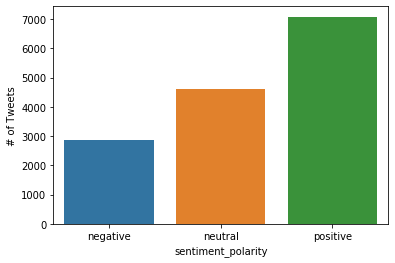

In [22]:
sns.barplot(data=sentiment_countdf, x='sentiment_polarity', y='id')
plt.ylabel('# of Tweets')

In [23]:
#create dataframes of positive and negative tweets
positive_tweets_df = df.loc[df['sentiment_polarity'] == 'positive']
negative_tweets_df = df.loc[df['sentiment_polarity'] == 'negative']

In [24]:
popular_tweets_df = df.loc[df['retweets_count'] > 50]
unpopular_tweets_df = df.loc[df['retweets_count'] < 50]

In [25]:
df.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'tweet', 'mentions', 'urls', 'photos',
       'replies_count', 'retweets_count', 'likes_count', 'hashtags',
       'cashtags', 'link', 'retweet', 'video', 'reply_to', 'tidy_tweet',
       'tokenized_tweet', 'lemmatized_tweets', 'tweet_sentiment',
       'sentiment_polarity'],
      dtype='object')

In [26]:
df.dropna('lemmatized_tweets', axis=0)

TypeError: dropna() got multiple values for argument 'axis'

### Save Cleaned data

In [27]:
df.to_csv('clean_billie_tweets.csv')

## EDA

### Open clean dataframe

In [28]:
clean_df = pd.read_csv('clean_billie_tweets.csv', index_col=0)


In [31]:
#let's explore the distribution of tweets by date

tweets_by_date = clean_df.groupby('date')['tweet'].count().reset_index()

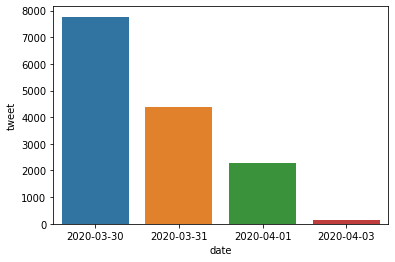

In [32]:
sns.barplot(data=tweets_by_date, x='date', y='tweet')

### Frequent Words - WordClouds

In [33]:
#let's visualize the most frequent words from the entire dataset

all_words = ' '.join([text for text in clean_df['lemmatized_tweets'] if type(text) != float])


In [34]:
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)


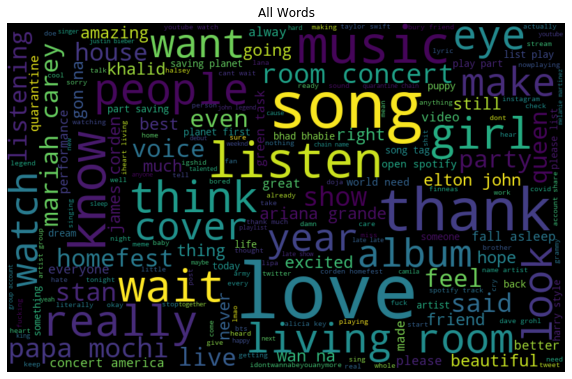

In [35]:
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('All Words')
plt.show()

In [36]:
#lets look out wordclouds for each date

march30_df = clean_df[clean_df['date'] == '2020-03-30']
march31_df = clean_df[clean_df['date'] == '2020-03-31']
april1_df = clean_df[clean_df['date'] == '2020-04-01']

m30_words = ' '.join([text for text in march30_df['lemmatized_tweets'] if type(text) != float])
m30_wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(m30_words)


m31_words = ' '.join([text for text in march31_df['lemmatized_tweets'] if type(text) != float])
m31_wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(m31_words)


a1_words = ' '.join([text for text in april1_df['lemmatized_tweets'] if type(text) != float])
a1_wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(a1_words)


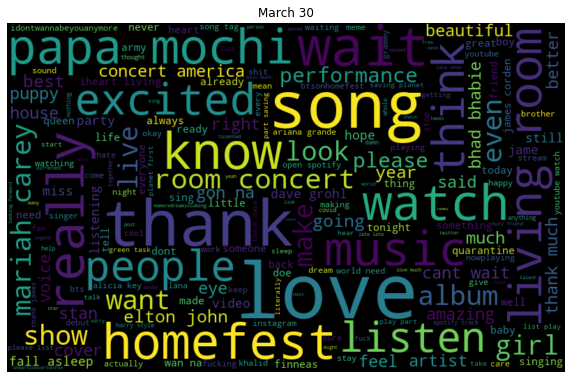

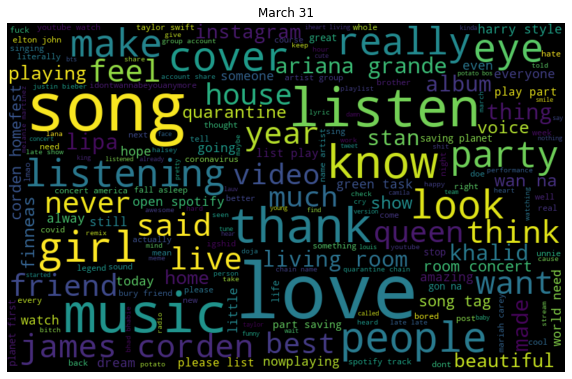

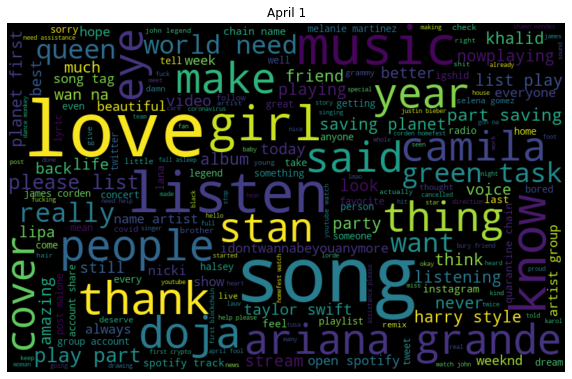

In [37]:


plt.figure(figsize=(10, 7))
plt.imshow(m30_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('March 30')
plt.show()

plt.figure(figsize=(10, 7))
plt.imshow(m31_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('March 31')
plt.show()

plt.figure(figsize=(10, 7))
plt.imshow(a1_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('April 1')
plt.show()

#### Most Frequent Words

In [38]:


# all_word_list = word_tokenize(all_words)
clean_df['lemmatized_tweets'].dropna(inplace=True)

In [39]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(clean_df['lemmatized_tweets'], 50)
for word, freq in common_words:
    print(word, freq)
df1 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df1.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in review after removing stop words')

like 1185
love 1144
song 1030
thank 580
music 494
watch 477
wait 466
http 457
concert 436
please 413
know 407
homefest 400
much 386
listen 375
really 369
need 363
james 350
artist 346
girl 307
would 300
people 297
show 292
play 276
na 276
home 273
year 271
look 271
think 265
make 262
room 255
live 252
friend 248
first 248
album 242
world 241
video 240
living 240
youtube 238
want 238
mochi 237
eye 232
cover 231
john 228
said 212
papa 209
thing 208
listening 197
coronavirus 197
best 196
voice 195


AttributeError: 'Series' object has no attribute 'iplot'

### Wordclouds for positive/negative tweets

In [ ]:
#let's visualize the most frequent words from the entire dataset

all_words_positive = ' '.join([text for text in positive_tweets_df['lemmatized_tweets'] if type(text) != float])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words_positive)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('All Words - Positive Tweets')
plt.show()

In [ ]:
# common_words = get_top_n_words(positive_tweets_df['lemmatized_tweets'], 50)
# for word, freq in common_words:
#     print(word, freq)
# df1 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
# df1.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
# kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in review after removing stop words')

In [ ]:
#wordcloud for negative tweets

all_words_negative = ' '.join([text for text in negative_tweets_df['lemmatized_tweets'] if type(text) != float])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words_negative)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('All Words - Negative Tweets')
plt.show()

In [ ]:
# common_words = get_top_n_words(negative_tweets_df['lemmatized_tweets'], 50)
# for word, freq in common_words:
#     print(word, freq)
# df1 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
# df1.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
# kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in review after removing stop words')

### Wordclouds for Popular/Unpopular Tweets

In [ ]:
#wordcloud for popular retweets (over 50)

all_words_popular = ' '.join([text for text in popular_tweets_df['lemmatized_tweets'] if type(text) != float])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words_popular)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('All Words - Popular Tweets')
plt.show()

In [ ]:
#wordcloud for unpopular retweets (less than 50)

all_words_unpopular = ' '.join([text for text in unpopular_tweets_df['lemmatized_tweets'] if type(text) != float])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words_unpopular)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('All Words - Unpopular Tweets')
plt.show()

### distribution of top unigrams after  stop words

In [ ]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(popular_tweets_df['lemmatized_tweets'], 20)

# for word, freq in common_words:
#     print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['Top Words' , 'count'])
sns.barplot(data=df2, x='Top Words', y='count')
plt.xticks(rotation=45)
plt.title('Top Words from Popular Tweets')
# df2.groupby('lemmatized_tweets').sum()['count'].sort_values(ascending=False).iplot(
#     kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in review after removing stop words')


In [ ]:
common_words = get_top_n_words(df['lemmatized_tweets'], 20)

# for word, freq in common_words:
#     print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['Top Words' , 'count'])
sns.barplot(data=df2, x='Top Words', y='count')
plt.xticks(rotation=45)
plt.title('Top Words from All Tweets')

### The distribution of top bigrams after removing stop words


In [ ]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(popular_tweets_df['lemmatized_tweets'], 20)
# for word, freq in common_words:
#     print(word, freq)
df3 = pd.DataFrame(common_words, columns = ['Top Words' , 'count'])

sns.barplot(data=df3, x='Top Words', y='count')
plt.xticks(rotation=45)
plt.title('Top Bigrams from Popular Tweets')



In [ ]:
common_words = get_top_n_bigram(df['lemmatized_tweets'], 20)
# for word, freq in common_words:
#     print(word, freq)
df4 = pd.DataFrame(common_words, columns = ['Top Words' , 'count'])

sns.barplot(data=df4, x='Top Words', y='count')
plt.xticks(rotation=45)
plt.title('Top Bigrams from All Tweets')


### TF-IDF
Let's calculate the importance of each word using TF-IDF scores. This will help us decide if there are other words we should be adding to our stopword list. Using non lemmatized words.

In [369]:
#drop rows with nan values in tweets
clean_df.dropna(axis=0, subset=['lemmatized_tweets'], inplace=True)

#### Vectorize Words

In [82]:
#create function to vectorize song

def count_vectorize(tweet, vocab=None):
    tokenized_tweet = word_tokenize(tweet)
    if vocab:
        unique_words = vocab
    else:
        unique_words = list(set(tokenized_tweet))
    
    tweet_dict = {i:0 for i in unique_words}
    
    for word in tokenized_tweet:
        tweet_dict[word] += 1
    
    return tweet_dict

In [83]:
BoW = count_vectorize(df['lemmatized_tweets'])

TypeError: expected string or bytes-like object

#### Term Frequency

In [84]:
#Term Frequency

#create term frequency function
def term_frequency(BoW_dict):
    total_word_count = sum(BoW_dict.values())
    
    for ind, val in BoW_dict.items():
        BoW_dict[ind] = val/ total_word_count
    
    return BoW_dict

BoW_dict = term_frequency(wordfreq)

NameError: name 'wordfreq' is not defined

{'fail': 1.1257331337033242e-05,
 'mercy': 4.502932534813297e-05,
 'try': 3.377199401109973e-05,
 'killed': 9.005865069626594e-05,
 'play': 0.003107023449021175,
 'player': 9.005865069626594e-05,
 'team': 0.0005290945728405624,
 'made': 0.0015535117245105874,
 'gracias': 2.2514662674066484e-05,
 'khalid': 0.0019137463272956513,
 'artist': 0.003895036642613502,
 'listen': 0.0042214992513874665,
 'would': 0.003377199401109973,
 'think': 0.0029831928043138095,
 'mine': 0.00032646260877396404,
 'sheeran': 0.0002364039580776981,
 'fuck': 0.0008668145129515597,
 'yassssssssssssssssss': 1.1257331337033242e-05,
 'gurl': 2.2514662674066484e-05,
 'got': 0.00025891862075176457,
 'ta': 0.00025891862075176457,
 'ranch': 1.1257331337033242e-05,
 'entitled': 5.6286656685166215e-05,
 'marry': 0.0002138892954036316,
 'also': 0.0015872837185216873,
 'like': 0.013339937634384394,
 'musician': 0.0005966385608627619,
 'gfdfhgh': 1.1257331337033242e-05,
 'paramore': 0.00012383064470736568,
 'direction': 0.0

#### Create List of Dictionaries

In [85]:
#create a list of dictionaries
def create_list_of_BoW(tweets):

    list_of_dictionaries = []

    for tweet in tweets:
        BoW = count_vectorize(tweet)

        list_of_dictionaries.append(BoW)
    return list_of_dictionaries

list_of_dictionaries = create_list_of_BoW(df['lemmatized_tweets'])


In [154]:
#create dictionary of corpus
wordfreq = {}
for tweet in df['lemmatized_tweets']:
    tokens = nltk.word_tokenize(tweet)
    for token in tokens:
        if token not in wordfreq.keys():
            wordfreq[token] = 1
        else:
            wordfreq[token] += 1

print(wordfreq)

{'fail': 1, 'mercy': 4, 'try': 3, 'killed': 8, 'play': 276, 'player': 8, 'team': 47, 'made': 138, 'gracias': 2, 'khalid': 170, 'artist': 346, 'listen': 375, 'would': 300, 'think': 265, 'mine': 29, 'sheeran': 21, 'fuck': 77, 'yassssssssssssssssss': 1, 'gurl': 2, 'got': 23, 'ta': 23, 'ranch': 1, 'entitled': 5, 'marry': 19, 'also': 141, 'like': 1185, 'musician': 53, 'gfdfhgh': 1, 'paramore': 11, 'direction': 35, 'louis': 69, 'harry': 132, 'solo': 15, 'state': 10, 'champ': 1, 'george': 3, 'michael': 24, 'waterparks': 6, 'jonas': 11, 'brother': 126, 'wonder': 33, 'looked': 20, 'pegged': 1, 'beliber': 1, 'however': 8, 'spell': 6, 'stupid': 56, 'thing': 208, 'listening': 197, 'lately': 10, 'dark': 34, 'cool': 83, 'stuff': 36, 'cross': 1, 'hope': 147, 'vibrator': 1, 'diva': 4, '#': 4530, 'nowplaying': 136, 'radio': 78, 'pritzwalk': 1, 'brandenburg': 2, 'ger': 2, 'name': 192, 'band': 58, 'mean': 128, 'people': 297, 'aries': 3, 'jakey': 1, 'peep': 17, 'donge': 1, 'markier': 1, 'current': 12, 'ha

#### Inverse Document Frequency

In [220]:
#Inverse Document Frequency
def inverse_document_frequency(list_of_dicts):
    vocab_set = set()
    # Iterate through list of dfs and add index to vocab_set
    for d in list_of_dicts:
        for word in d.keys():
            vocab_set.add(word)
    
    # Once vocab set is complete, create an empty dictionary with a key for each word and value of 0.
    full_vocab_dict = {i:0 for i in vocab_set}
    
    # Loop through each word in full_vocab_dict
    for word, val in full_vocab_dict.items():
        docs = 0
        
        # Loop through list of dicts.  Each time a dictionary contains the word, increment docs by 1
        for d in list_of_dicts:
            if word in d:
                docs += 1
        
        # Now that we know denominator for equation, compute and set IDF value for word
        
        full_vocab_dict[word] = np.log((len(list_of_dicts)/ float(docs)))
    
    return full_vocab_dict

In [221]:
tf_idf_dict = inverse_document_frequency(list_of_dictionaries)

In [278]:

stop_word_dict = []
for k,v in (tf_idf_dict.items()):
    if tf_idf_dict[k] < 6:
        stop_word_dict.append((k,v))

print(stop_word_dict)
        

[('meet', 5.989100644178637), ('iheart', 4.535666980221118), ('famous', 5.743978186145652), ('backstreet', 5.9350334229083614), ('saving', 4.744305845332446), ('still', 4.595885840214173), ('thought', 5.141802783791433), ('getting', 5.309939705593432), ('felt', 5.478275020412647), ('probably', 5.834949964351378), ('dear', 5.909057936505101), ('kpop', 5.811419466941184), ('band', 5.529568314800197), ('seen', 5.445485197589655), ('want', 4.130201872112953), ('watch', 3.4545223845933988), ('spotify', 4.325595510474261), ('definitely', 5.961701669990522), ('march', 5.7659570928644275), ('book', 5.9350334229083614), ('pentatonix', 5.701418571726856), ('streaming', 5.640793949910421), ('doja', 5.040020089481491), ('stupid', 5.660596577206601), ('lorde', 5.909057936505101), ('person', 5.338513078037487), ('true', 5.811419466941184), ('ticket', 5.701418571726856), ('chain', 5.35311187745864), ('first', 4.07136137209002), ('troye', 5.961701669990522), ('alicia', 5.309939705593432), ('btsonhomef

In [54]:
#find min and max TF-IDF value in corpus

key_max = max(tf_idf_dict.keys(), key=(lambda k: tf_idf_dict[k]))
key_min = min(tf_idf_dict.keys(), key=(lambda k: tf_idf_dict[k]))

print('Maximum Value: ',tf_idf_dict[key_max])
print('Minimum Value: ',tf_idf_dict[key_min])

Maximum Value:  9.58293787645873
Minimum Value:  0.40843195749176353


### Modeling

#### LDA & NMF Models using TF and TFIDF

In [29]:

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

no_features = 5000

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=50, max_features=no_features, ngram_range=(2,3))
tfidf = tfidf_vectorizer.fit_transform(df['lemmatized_tweets'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=50, max_features=no_features, ngram_range=(2,3))
tf = tf_vectorizer.fit_transform(df['lemmatized_tweets'])
tf_feature_names = tf_vectorizer.get_feature_names()

In [49]:
from sklearn.decomposition import NMF, LatentDirichletAllocation



# Run NMF
nmf = NMF(n_components=4, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Run LDA
lda = LatentDirichletAllocation(n_components=4, max_iter=5, learning_method='online', learning_offset=50.,random_state=0, ).fit(tf)


In [31]:
#create a function to display topic results
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))




In [32]:
#display topics from nmf model
no_top_words = 5
display_topics(nmf, tfidf_feature_names, no_top_words)

Topic 0:
papa mochi thank much cant wait love much group like
Topic 1:
living room room concert living room concert mariah carey concert america
Topic 2:
look like bhad bhabie ariana grande youtube watch john legend
Topic 3:
green task world need saving planet part saving planet part saving


In [33]:
#display topics from lda model
display_topics(lda, tf_feature_names, no_top_words)

Topic 0:
ariana grande harry style taylor swift name artist group like
Topic 1:
bhad bhabie green task world need saving planet part saving planet
Topic 2:
papa mochi look like open spotify youtube watch spotify track
Topic 3:
living room room concert living room concert mariah carey elton john


#### LDA Modeling with Gensim

In [43]:
import pyLDAvis.gensim
import gensim
from gensim import corpora

# import graphlab as gl
# import pyLDAvis.graphlab

In [127]:
data_ready = [word.split() for word in df['lemmatized_tweets']]
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

In [168]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True, )

TypeError: 'module' object is not callable

In [46]:
# turn on automatic rendering of visualizations
pyLDAvis.enable_notebook()

In [47]:
pyLDAvis.gensim.prepare(lda_model, corpus, id2word, )

C:\Users\jacks\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.098586  0.220429       1        1  27.352137
0     -0.264236  0.105109       2        1  26.960745
2      0.240001 -0.057775       3        1  26.003902
3     -0.074350 -0.267764       4        1  19.683208, topic_info=      Category         Freq              Term        Total  loglift  logprob
57     Default  4424.000000                 #  4424.000000  30.0000  30.0000
32     Default  1137.000000              like  1137.000000  29.0000  29.0000
481    Default   805.000000           youtube   805.000000  28.0000  28.0000
139    Default   947.000000              love   947.000000  27.0000  27.0000
127    Default   905.000000              song   905.000000  26.0000  26.0000
...        ...          ...               ...          ...      ...      ...
12289   Topic4   171.560013         qualified   218.683777   1.3827  -4.6241
5978    Topic4   171.560013   billieeilishmnl   218.683777   1.3827  -4.6241
3795    Topic4   171.560013        electronic   218.683777   1.3827  -4.6241
12288   Topic4   171.560013  billieeilishasia   218.683777   1.3827  -4.6241
12290   Topic4   171.560013            raffle   218.683777   1.3827  -4.6241

[170 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
57        2  0.999930        #
174       4  0.997111    album
221       3  0.993515  amazing
94        1  0.993466  america
131       3  0.992510   ariana
...     ...       ...      ...
314       4  0.990768     week
416       2  0.999283    world
15        1  0.996642    would
341       1  0.999125     year
481       4  0.999687  youtube

[173 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3, 4])

#### LDA Modeling with Gemsin using bigrams

In [72]:

import gensim
from gensim.utils import simple_preprocess
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
        
data = df['lemmatized_tweets'].values.tolist()
data_words = list(sent_to_words(data))

In [165]:
docs = df['lemmatized_tweets']
bigrams1 = gensim.models.Phrases(docs, min_count=10)
for idx in range(len(docs)):
    for token in bigrams1[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [73]:
bigrams = gensim.models.Phrases(data_words)
bigram_mod = gensim.models.phrases.Phraser(bigrams)

In [75]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [134]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]


def lemmatization(texts):

    texts_out = []
    for sent in texts:
        doc = " ".join(sent)
        texts_out.append(str(doc))
    return texts_out




In [135]:
import spacy
#Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Form Bigrams
words_bigrams = make_bigrams(data_words)
                 

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(words_bigrams)
# print(data_lemmatized[:2])
# data_words

In [167]:
import gensim.corpora as corpora
# Create Dictionary
id2word1 = corpora.Dictionary(data_words)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word1.doc2bow(text) for text in data_words]

In [173]:
# Build LDA model
lda_model_bigram = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word1,
                                       num_topics=4, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

##### GemsinLDA Results - pyLDAvis

In [176]:
pyLDA_bigram_vis = pyLDAvis.gensim.prepare(lda_model_bigram, corpus, id2word1)

C:\Users\jacks\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [178]:
pyLDAvis.show(pyLDA_bigram_vis, "pyvisual.html")

### t-SNE Clustering Chart

In [78]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

In [97]:
# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 13255 samples in 0.010s...
[t-SNE] Computed neighbors for 13255 samples in 0.441s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13255
[t-SNE] Computed conditional probabilities for sample 2000 / 13255
[t-SNE] Computed conditional probabilities for sample 3000 / 13255
[t-SNE] Computed conditional probabilities for sample 4000 / 13255
[t-SNE] Computed conditional probabilities for sample 5000 / 13255
[t-SNE] Computed conditional probabilities for sample 6000 / 13255
[t-SNE] Computed conditional probabilities for sample 7000 / 13255
[t-SNE] Computed conditional probabilities for sample 8000 / 13255
[t-SNE] Computed conditional probabilities for sample 9000 / 13255
[t-SNE] Computed conditional probabilities for sample 10000 / 13255
[t-SNE] Computed conditional probabilities for sample 11000 / 13255
[t-SNE] Computed conditional probabilities for sample 12000 / 13255
[t-SNE] Computed conditional probabilities for sam

Loading BokehJS ...

NameError: name 'mcolors' is not defined